# 参考資料
**書籍**


**Kaggle**
- [Liver Cirrhosis | Survival Prediction | Multiclass](https://www.kaggle.com/code/ashishkumarak/liver-cirrhosis-survival-prediction-multiclass)
- [PS3E26 🔥 | Liver Cirrhosis](https://www.kaggle.com/code/ashishkumarak/ps3e26-liver-cirrhosis-survival-prediction)


**自分で作成したファイル**
- Home_Credit_Default_Risk

**その他**


## ライブラリ・データセットのインポート

In [47]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [48]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

## 実行時間を調べるために使う

In [49]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [50]:
FILE_PATH = ''
OUTPUT_DIR = ''

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

test_id = test['id']

target = train['Status']

target_name = str(train.iloc[:, [18]].columns.tolist()) # カラム数-2の値が目的変数

df = pd.concat([train, test], axis=0)
df.reset_index(inplace=True)

# 説明変数をデータ型ごとに代入する
numerical_features = df._get_numeric_data().columns
categorical_features = df.drop(numerical_features, axis=1).columns

numerical_features = numerical_features.drop('id')

In [51]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head(10)

,index,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
5,5,5,703,D-penicillamine,19270,F,N,Y,N,N,0.6,227.0,3.46,34.0,6456.2,60.63,68.0,213.0,11.5,3.0,D
6,6,6,1300,Placebo,17703,F,N,N,N,N,1.0,328.0,3.35,43.0,1677.0,137.95,90.0,291.0,9.8,3.0,C
7,7,7,1615,Placebo,21281,F,N,Y,N,N,0.6,273.0,3.94,36.0,598.0,52.70,214.0,227.0,9.9,3.0,C
8,8,8,2050,D-penicillamine,20684,F,N,N,N,N,0.7,360.0,3.65,72.0,3196.0,94.55,154.0,269.0,9.8,2.0,C
9,9,9,2615,D-penicillamine,15009,F,N,N,N,N,0.9,478.0,3.60,39.0,1758.0,171.00,140.0,234.0,10.6,2.0,C


## 前処理

### 欠損値の補完

In [52]:
def missing_values(df):

    return df

### 外れ値の削除

In [53]:
def outlier(df):

    return df

### スケーリング（標準化）

- MinMaxScaler(正規化)

In [54]:
def scaling(df):
    df_scale = df[numerical_features]
    sc = MinMaxScaler()
    df[numerical_features] = pd.DataFrame(sc.fit_transform(df_scale), columns = df_scale.columns)

    return df

## 特徴量エンジニアリング

### 特徴量の作成

In [55]:
def create_new_features(df):
    # 血小板減少症インジケーター
    threshold_platelets = 150 # 閾値
    df['thrombocytopenia'] = np.where(df['Platelets'] < threshold_platelets, 1, 0)

    # アルカリ性リン酸塩ホスファターゼの上昇指標：
    threshold_alk_phos_upper = 147
    threshold_alk_phos_lower = 44
    df['elevated_alk_phos'] = np.where((df['Alk_Phos'] > threshold_alk_phos_upper) | (df['Alk_Phos'] < threshold_alk_phos_lower), 1, 0)

    # 正常な銅レベル
    normal_copper_range = (62, 140)
    df['normal_copper'] = np.where((df['Copper'] >= normal_copper_range[0]) & (df['Copper'] <= normal_copper_range[1]), 1, 0)

    # アルブミンの正常範囲
    normal_albumin_range = (3.4, 5.4)
    df['normal_albumin'] = np.where((df['Albumin'] >= normal_albumin_range[1]), 1, 0)

    # 正常なビリルビンレベル
    normal_bilirubin_range = (0.2, 1.2)
    df['normal_bilirubin'] = np.where((df['Bilirubin'] >= normal_bilirubin_range[0]) & (df['Bilirubin'] <= normal_bilirubin_range[1]), 1, 0)

    # 診断日
    df['DiagnosisDays'] = df['Age'] - df['N_Days']

    # ビリルビン * アルブミン
    df['Bilirubin_Albumin'] = df['Bilirubin'] * df['Albumin']

    # 症状のスコア
    symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders']
    df['Symptom_Score'] = df[symptom_columns].sum(axis=1)

    # 肝臓機能
    liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
    df['Liver_Function_Index'] = df[liver_columns].mean(axis=1)

    # リスクスコア
    df['Risk_Score'] = df['Bilirubin'] + df['Albumin'] - df['Alk_Phos']

    # 時間特徴量
    df['Diag_Year'] = (df['N_Days'] / 365).astype(int)
    df['Diag_Month'] = ((df['N_Days'] % 365) / 30).astype(int)

    return df

#### 年齢に関する特徴量の作成

In [56]:
def convert_days_to_years(age_in_days):
    days_in_year = 365.25
    age_in_years = age_in_days / days_in_year

    return age_in_years

def add_cols(df):
    age = list(df.Age)
    age_in_year = []
    for i in age:
        age_in_year.append(int(convert_days_to_years(i)))
    df['Age_in_year'] = pd.Series(age_in_year)

    return df

### カテゴリ変数のエンコーディング

- LabelEncoding

In [57]:
def label_encoder(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    categorical_columns = categorical_columns.drop('Status')

    for column in categorical_columns:
        df[column] = df[column].fillna('').astype('str') # 欠損値の補完をする
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])

    # 目的変数を数値化(int64)する
    df['Status'] = df['Status'].map({"D": 0, "CL": 1, "C": 2})
    # 一緒にラベルエンコーディングすると、1,2,3になってしまいモデル学習できないため分割する

    return df

### 特徴量の選択

#### 特徴量の重要度評価

In [58]:
def feature_importance_evaluation(df):
    # 訓練データをX(説明変数)とy（目的変数）に分割する
    X = df.select_dtypes(include=['float', 'int'])
    X = X.drop(['Status'], axis=1) # 目的変数を指定する
    y = target # 目的変数を指定する

    for column in X.columns.tolist():
        X[column] = X[column].apply(lambda x: np.log(x + 1))

    # 特徴量の重要度評価
    lgb = LGBMClassifier(
        random_state=42,
    )

    lgb.fit(X, y)
    importance = lgb.feature_importances_

    feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
        .sort_values(ascending=True, by='importance')

    return feature_importance

#### 特徴量の削除

In [59]:
def drop_columns(df):
    drop_list = [
        'index'
    ]
    dropped_df = df.drop(columns=drop_list)

    return dropped_df

### データセットの更新

In [60]:
# 前処理
df = add_cols(df)
df = missing_values(df)
df = outlier(df)
# df = scaling(df) # 標準化したい時のみ実行する

# 特徴量エンジニアリング
df = create_new_features(df)
df = drop_columns(df)
df = label_encoder(df)

In [61]:
train = df[df.loc[:, 'id'] < 7905]
test = df[df.loc[:, 'id'] >= 7905]

train_x = train.drop(columns=['Status', 'id'])
train_y = target
test_x = test.drop(columns=['Status', 'id'])

X = train_x.values
y = train_y.values
# y = y.astype(int)

df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Age_in_year,thrombocytopenia,elevated_alk_phos,normal_copper,normal_albumin,normal_bilirubin,DiagnosisDays,Bilirubin_Albumin,Symptom_Score,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month
0,0,999,0,21532,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,0.0,58,0,1,0,0,0,20533,7.705,0,446.6125,-1595.35,2,8
1,1,2574,1,19237,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,2.0,52,0,1,1,0,1,16663,3.186,0,394.8225,-1435.56,7,0
2,2,3428,1,13727,0,0,1,1,2,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,0.0,37,0,1,1,0,0,10299,11.715,3,288.8000,-1022.15,9,4
3,3,2576,1,18460,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,2.0,50,0,1,0,0,1,15884,2.100,0,432.1000,-1648.90,7,0
4,4,788,1,16658,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,2.0,45,0,1,1,0,1,15870,4.015,2,327.8250,-1176.25,2,1


In [62]:
# 特徴量の重要度評価
train_importance = train.drop(['id'], axis=1)
feature_importance = feature_importance_evaluation(train_importance)
feature_importance

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 7905, number of used features: 28
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start training from score -1.087291


,importance
Risk_Score,0
normal_albumin,0
elevated_alk_phos,0
thrombocytopenia,0
Ascites,2
normal_bilirubin,2
Diag_Year,5
Hepatomegaly,16
Age_in_year,19
Spiders,28


<Axes: >

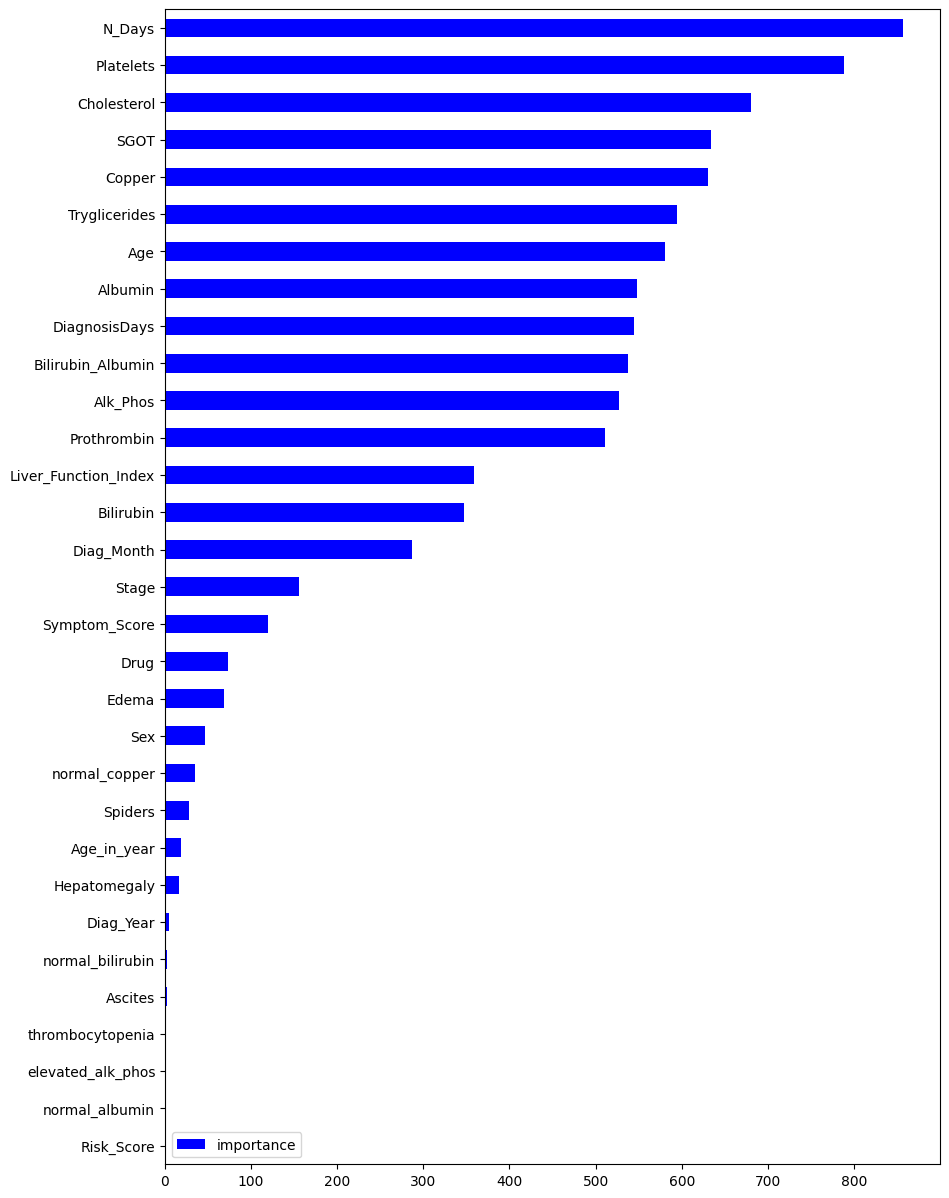

In [63]:
feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [64]:
df.to_csv(OUTPUT_DIR + 'data.csv', index=False)

In [65]:
def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:7905].reset_index(drop=True)
    test = data[7905:].reset_index(drop=True).drop('Status', axis=1)
    # 目的変数と説明変数に分割
    X = train.drop('Status', axis=1)
    y = train['Status'].values
    return data,test,train,X,y

In [66]:
filename = 'data.csv'
data,test,train,X,y = file_to_xy(filename)

読み込み完了 data.csv


In [67]:
import pandas as pd
from xgboost import XGBClassifier # モデル作成

def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:7905].reset_index(drop=True)
    test = data[7905:].reset_index(drop=True).drop('Status', axis=1)
    # 目的変数と説明変数に分割
    X = train.drop('Status', axis=1)
    y = train['Status'].values
    return data,test,train,X,y

filename = 'data.csv'
data,test,train,X,y = file_to_xy(filename)

# モデル作成
model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(X, y)

pred = model.predict_proba(test)
pred = pd.DataFrame(pred)

pred.columns = ["Status_C", "Status_CL", "Status_D"]
# pred.head()

# 提出
submission_df = pd.DataFrame()
submission_df = pred
submission_df['id'] = test_id
submission_df = submission_df['id'].apply(lambda x: int(x))
submission_df = pd.concat([pred], axis=1)
# submission_df.head()

submission_df.to_csv('submission.csv', index=False)

読み込み完了 data.csv
